# Multi-Layer Perceptron

## Introduction

In this homework we will be discussing and implementing a multi-layer perceptron (MLP). The perceprton model was developed in 1969 by Minsky and Papert, and it is inspired in biological neurons. The model of a single neuron (perceptron) consists in various weights for the different inputs, which are passed through a weighted sum and an activation function to produce an output. There are different activation functions like the sigmoid, tanh or ReLU. Below, we can see a representation of a single perceptron.
<center><img src="imgs/perceptron.png" width = "300"/></center>

Multi-Layer Perceptrons consist in a feedforward network of many layers. Each layer has various perceptrons, which outputs are treated as the input of the next layer; fully connected layers like these are called *Dense Layers*. In the following image we can see a multi-layer perceptron, each of the nodes in the graph are perceptrons.
<center><img src="imgs/neural_network.png" width = "300"/></center>

## Imports and utility functions

In [30]:
using DelimitedFiles
using Statistics
using LinearAlgebra
using Plots

In [29]:
function append_ones(mat::Matrix{Float64})
    """
    Function to append a row of ones at the end of a matrix. This is for the biases in a
    neuron.
    
    Input:
        mat(Matrix{Float64}): matrix
    
    Output:
        Matrix with row of ones at the end.
    """
    return vcat(mat, ones(1, size(mat, 2)))
end;

## Activation Functions

In [1]:
abstract type ActivationFunction end;

### Linear

In [2]:
linear_activation(params::Matrix{Float64}, input::Matrix{Float64}) = params * append_ones(input);

In [3]:
struct LinearActivation <: ActivationFunction
    func::Function
    derivative::Function
    function LinearActivation()
        new(linear_activation, x -> 1)
    end
end;

### Sigmoid

Sigmoid activation function looks like:
$$
\begin{align}
sigmoid(x) &= \frac{1}{1+e^{-x}}\\
&= \frac{e^x}{e^x+1}
\end{align}
$$
<center><img src="imgs/sigmoid.png" width = "200"/></center>

In [4]:
sigmoid_activation(params::Matrix{Float64}, input::Matrix{Float64}) = 1.0 ./ (1 .+ exp.(-params * append_ones(input)));

In [5]:
sigmoid_derivative(input::Matrix{Float64}) = input .* (-input .+ 1);

In [6]:
struct Sigmoid_Activation <: ActivationFunction
    func::Function
    derivative::Function
    function Sigmoid_Activation()
        new(sigmoid_activation, sigmoid_derivative)
    end
end;

### ReLU

ReLU activation function looks like:
$$
f(x)=
\begin{cases}
0, \qquad x<0\\
x, \qquad x\ge0
\end{cases}
$$
<center><img src="imgs/relu.png" width = "200"/></center>

In [7]:
function relu_activation(params::Matrix{Float64}, input::Matrix{Float64})
    z = params * append_ones(input)
    return z .* (z .> 0)
end;

In [8]:
function relu_derivative(input::Matrix{Float64})
    return Int.(input.>0)
end;

In [9]:
struct ReLU_Activation <: ActivationFunction
    func::Function
    derivative::Function
    function ReLU_Activation()
        new(relu_activation, relu_derivative)
    end
end;

### Tanh

Tanh is the hyperbolic tangent, described as:
$$
\tanh(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$
<center><img src="imgs/tanh.png" width = "200"/></center>

In [10]:
tanh_activation(params::Matrix{Float64}, input::Matrix{Float64}) = tanh.(params*append_ones(input));   

In [11]:
tanh_derivative(input::Matrix{Float64}) = sech.(input).^2;

In [12]:
struct Tanh_Activation <: ActivationFunction
    func::Function
    derivative::Function
    function Tanh_Activation()
        new(tanh_activation, tanh_derivative)
    end
end;

### Softmax

Softmax is an activation function that only works for normalization.
$$
\sigma_k(x) = \frac{e^{x_k}}{\sum_i^N e^{x_i}}
$$

In [13]:
function softmax_activation(params::Matrix{Float64}, input::Matrix{Float64})
    """
    Stable form of softmax function. Other form has numerical stability issues so
    this form is used to fix that.
    """
    exps = input.-maximum(input, dims=1)
    return exp.(exps)./sum(exp.(exps), dims=1)
end;

In [14]:
struct Softmax_Activation <: ActivationFunction
    func::Function
    function Softmax_Activation()
        new(softmax_activation)
    end
end;

## Layers

First we define an abstract type of a layer, because there are different types of layers, then we can code the type of a dense layer.

In [15]:
abstract type Layer end

In [16]:
struct Dense <: Layer
    """
    Layer with fully connected neurons.
    """
    input_size::Int64
    num_neurons::Int64
    parameters::Matrix{Float64}
    activation::ActivationFunction
    
    function Dense(input_size::Int, num_neurons::Int, activation::ActivationFunction)
        parameters = randn(num_neurons, input_size + 1) # adding 1 col for biases
        return new(input_size, num_neurons, parameters, activation)
    end
end

In [17]:
struct Softmax <: Layer
    """
    Layer with an exponential normalizer (softmax activation) activation function.
    This layer is normally used only as the last layer of a neural network to normalize
    the outputs before the prediction.
    """
    parameters::Matrix{Float64}
    activation::ActivationFunction
    num_neurons::Int64
    
    function Softmax(num_neurons::Int)
        return new(Matrix{Float64}(undef,0,0), Softmax_Activation(), num_neurons)
    end
end;

Now we define a neural network. Which is the generalized form of a MLP. A neural network is really just many layers with an optimization function.

In [18]:
struct NetworkArchitecture
    """
    Structure for complete neural network.
    """
    layers::Array{Layer}
    
    function NetworkArchitecture(first_layer::Layer)
        return new([first_layer])
    end
end

We add functions to add new layers and to predict data from an input.

In [19]:
function add_Dense_Layer!(network::NetworkArchitecture, num_neurons::Int64, activation::ActivationFunction)
    """
    Adds a dense layer to the end of a neural network.
    """
    input_size = network.layers[end].num_neurons
    new_layer = Dense(input_size, num_neurons, activation)
    push!(network.layers, new_layer)
end;

In [20]:
function add_Softmax_Layer!(network::NetworkArchitecture)
    """
    Adds a softmax layer at the end of a neural network.
    """
    num_neurons = input_size = network.layers[end].num_neurons
    push!(network.layers, Softmax(num_neurons))
end;

In [21]:
function predict(network::NetworkArchitecture, input::Matrix{Float64})
    """
    Predicts the output of a neural network with a certain input.
    """
    res = input
    for layer in network.layers
        res = layer.activation.func(layer.parameters, res)
    end
    return res
end;

Now we try it!

In [22]:
data_len = 100;
num_classes = 10;

In [23]:
input = randn(784,data_len);

In [24]:
labels = mapslices(x -> begin x[rand(1:num_classes,1)] .= 1; x end, zeros(num_classes,data_len) , dims = 1);

In [25]:
first_layer = Dense(784, 250, Sigmoid_Activation())
network = NetworkArchitecture(first_layer)
add_Dense_Layer!(network, 50, Sigmoid_Activation());
add_Dense_Layer!(network, num_classes, Sigmoid_Activation());
add_Softmax_Layer!(network);

In [31]:
preds = predict(network, input)

10×100 Matrix{Float64}:
 0.104113   0.135372   0.129367   …  0.113706   0.116616   0.122785
 0.117188   0.134647   0.127172      0.120783   0.107223   0.115575
 0.116224   0.0502303  0.0482776     0.0514839  0.0757315  0.0756556
 0.097332   0.117045   0.100213      0.119868   0.11386    0.10919
 0.0439313  0.0499538  0.0481519     0.0446153  0.0523767  0.0455138
 0.117683   0.0565894  0.120448   …  0.112181   0.0916811  0.123629
 0.117908   0.135331   0.130043      0.120663   0.116778   0.123537
 0.115647   0.134326   0.118391      0.118304   0.0968525  0.114995
 0.117918   0.133818   0.129963      0.120703   0.116797   0.123425
 0.0520573  0.0526872  0.0479729     0.0776938  0.112083   0.0456949

In [32]:
sum(preds, dims=1)

1×100 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0

## Error function

Here we have a choice of using two different functions: cross-entropy and squared error function. There are different papers showing that cross-entropy gets stuck less often in worse local minima, but with a good initial position squared error perfoms better. Since we have been using the squared error function in previous homeworks we will be keeping the same error function.

In [33]:
function root_mean_squared_error(preds::Matrix{Float64}, labels::Matrix{Float64})
    """
    Minimum mean square error function. Calculates error of prediction with:
    sqrt(sum((prediction-labels)^2))/2m.
    """
    m = size(labels,1)
    preds = transpose(mapslices(sum,preds;dims = 1))
    return norm(preds-labels,2)/2m
end;

In [34]:
function cross_entropy_error(prediction::Matrix{Float64}, labels::Matrix{Float64})
    """
    Calculates cross entropy error with:
    -1/n sum(log(sigma_y(x))).
    """
    probs = sum(prediction .* labels, dims =1)
    return -sum(log.(probs))/length(probs)
end;

In [35]:
function calculate_error(network::NetworkArchitecture, input::Matrix{Float64}, labels::Matrix{Float64}; error_function::Function = cross_entropy_error)
    """
    Calculates the error of the output of a neural network for a supervized learning problem.
    The default method to calculate the error is with RMSE(root mean squared error).
    """
    preds = predict(network, input)
    return error_function(preds,labels)
end;

## Backpropagation

In [64]:
struct BackPropagationUnit
    network::NetworkArchitecture
    batch::Matrix{Float64}
    outputs::Array{Matrix{Float64}}
    deltas::Array{Matrix{Float64}}
    
    function BackPropagationUnit(network::NetworkArchitecture, batch::Matrix{Float64}, labels::Matrix{Float64})
        outputs = forwardPass(network, batch)
        deltas = backwardPass(network, outputs, labels)
        return new(network, batch, outputs, deltas)
    end
end;

In [37]:
function forwardPass(network::NetworkArchitecture, batch::Matrix{Float64})
    res = [batch]
    for l in network.layers
        push!(res, l.activation.func(l.parameters, res[end]))
    end
    return res
end;

To calculate the deltas of the last layer we can do it by
$$
\delta_m = (\hat{y}-y)g_0'(a_m)
$$
Where $g_0'$ is the layer's derivative and $a_m$ is the activation of layer $m$.
Then, we calculate the previous layers by
$$
\delta_k = g'(a_k)\quad (W_{k+1}\cdot \delta_{k+1})
$$

In [38]:
function backwardPass(network::NetworkArchitecture, outputs::Array{Matrix{Float64}}, labels::Matrix{Float64})
    """
    Backward pass for backpropagations in neural networks.
    
    It is assumed that last layer is Softmax layer. When 
    Softmax layer is derived with cross entropy error then
    derivative = output-labels. So we skip this layer.
    """
    deltas = []
    error = outputs[end]-labels
    push!(deltas,error .* network.layers[end-1].activation.derivative(outputs[end-1]))
    for i in 2:(length(network.layers)-1)
        higher_layer = network.layers[end - i + 1]
        der = network.layers[end - i].activation.derivative(outputs[end-i])
        push!(deltas, der .* (transpose(higher_layer.parameters[:,(1:end-1)]) * deltas[end]))
    end
    return reverse(deltas)
end;

### Optimizers

In [39]:
abstract type Optimizer end;
abstract type OptimizerContext end;

#### SGD

In [40]:
struct SGDParameters <: OptimizerContext
    learningRate::Float64
    momentum::Float64
    velocity::Array{Array{Float64,2}}
end;

In [41]:
struct SGD <: Optimizer
    params::OptimizerContext
    updateFunc!::Function
    function SGD(network::NetworkArchitecture, learningRate::Float64; momentum = 0)
        velocity = [zeros(size(layer.parameters)) for layer in network.layers[1:end-1]]
        return new(SGDParameters(learningRate, momentum, velocity), sgd_update!)
    end;
end;

In [42]:
function sgd_update!(bpu::BackPropagationUnit, params::OptimizerContext)
    Threads.@threads for i in 1:(length(bpu.network.layers) - 1)
        weight_derivative = (bpu.deltas[i] * transpose(bpu.outputs[i]))/size(bpu.batch)[2];
        bias_derivative = mean(bpu.deltas[i],dims=2);
        
        params.velocity[i] *= params.momentum
        params.velocity[i][:,1:end-1] += weight_derivative
        params.velocity[i][:,end] += bias_derivative
        
        bpu.network.layers[i].parameters[:,1:(end-1)]-=params.learningRate * params.velocity[i][:,1:end-1];
        bpu.network.layers[i].parameters[:,end]-=params.learningRate * params.velocity[i][:,end];
    end;
end;

In [69]:
function epoch!(network::NetworkArchitecture, optimizer::Optimizer, data::Matrix{Float64}, labels::Matrix{Float64})
    bpu = BackPropagationUnit(network, data, labels)
    optimizer.updateFunc!(bpu, optimizer.params)
end;

## Testing

In [ ]:
train_x = readdlm("./train_X.csv", ',', Float64)
train_y = readdlm("./train_y.csv", ',', Float64)
test_x = readdlm("./test_x.csv", ',', Float64)
test_y = readdlm("./test_y.csv", ',', Float64)

In [83]:
first_layer = Dense(784, 512, ReLU_Activation())
network = NetworkArchitecture(first_layer)
add_Dense_Layer!(network, 128, ReLU_Activation());
add_Dense_Layer!(network, 56, ReLU_Activation());
add_Dense_Layer!(network, 10, Sigmoid_Activation());
add_Softmax_Layer!(network);

In [84]:
calculate_error(network, train_x, train_y)

2.4350297912584753

In [85]:
sgd = SGD(network, 30.0);

In [87]:
error_train = [calculate_error(network, train_x, train_y)]
error_test = [calculate_error(network, test_x, test_y)]

1-element Vector{Float64}:
 2.4334070737912032

In [ ]:
NUM_EPOCHS = 100;

In [96]:
i=0
while error_train[end]>1e-3 && i<NUM_EPOCHS
    epoch!(network, sgd, train_x, train_y)
    e = calculate_error(network, train_x, train_y)
    push!(error_train, e)
    push!(error_test, calculate_error(network, test_x, test_y))
    i+=1
end;

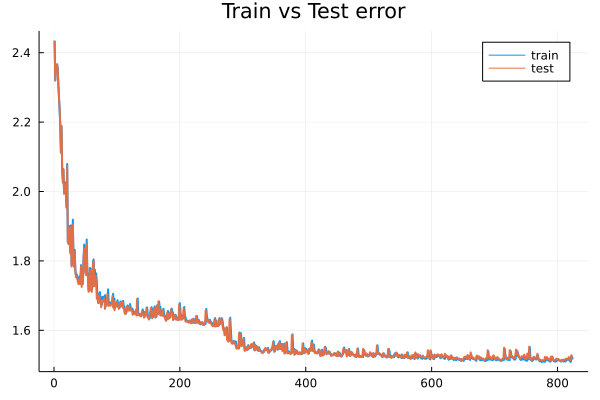

In [97]:
plot(error_train, title = "Train vs Test error", label = "train", lw = 2)
plot!(error_test, label = "test", lw = 2)

In [120]:
predictions = predict(network, test_x)

10×10000 Matrix{Float64}:
 0.0853367  0.0853367  0.0853367  …  0.0853367  0.0853367  0.0853367
 0.0853367  0.0853367  0.231969      0.0853367  0.0853367  0.0853367
 0.0853367  0.231969   0.0853367     0.0853367  0.0853367  0.0853367
 0.0853367  0.0853367  0.0853367     0.0853367  0.0853367  0.0853367
 0.0853367  0.0853367  0.0853367     0.231969   0.0853367  0.0853367
 0.0853367  0.0853367  0.0853367  …  0.0853367  0.231969   0.0853367
 0.0853367  0.0853367  0.0853367     0.0853367  0.0853367  0.231969
 0.231969   0.0853367  0.0853367     0.0853367  0.0853367  0.0853367
 0.0853367  0.0853367  0.0853367     0.0853367  0.0853367  0.0853367
 0.0853367  0.0853367  0.0853367     0.0853367  0.0853367  0.0853367

In [127]:
preds = (floor.(predictions .- maximum(predictions, dims =1)).+1);

In [130]:
mat = preds * test_y'

10×10 Matrix{Float64}:
 964.0     1.0    13.0    4.0    2.0   27.0   15.0    2.0   19.0   12.0
   6.0  1121.0     3.0    4.0    1.0   16.0    7.0    8.0   12.0   17.0
  10.0   144.0  1012.0  145.0   18.0   29.0   35.0  133.0   92.0   11.0
   6.0     4.0    12.0  942.0    1.0   76.0    6.0    4.0   28.0   16.0
   8.0     5.0    24.0    2.0  976.0   38.0   45.0   16.0   66.0  110.0
  11.0     1.0     3.0   75.0    1.0  831.0   18.0    2.0   32.0   14.0
  25.0     4.0     7.0    3.0    6.0   46.0  929.0    2.0   32.0   10.0
  12.0     8.0    33.0   23.0    3.0   21.0    5.0  993.0   16.0   42.0
   8.0    11.0    25.0   41.0    4.0   38.0    8.0    4.0  913.0   22.0
   7.0     1.0     3.0    5.0   34.0   25.0    4.0   24.0   22.0  935.0

In [141]:
score = sum([mat[i,i] for i in 1:size(mat,1)])/sum(mat)

0.8282515073212747

In [199]:
train_y

10×60000 Matrix{Float64}:
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [173]:
using MLDatasets

In [176]:
using Images

In [174]:
t, _ = MNIST.testdata();

,,,,,,,,,

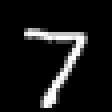
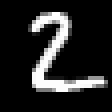
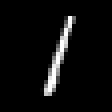
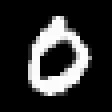
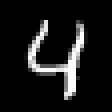
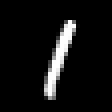
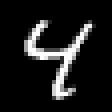
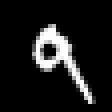
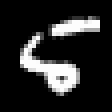
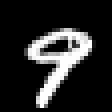

In [184]:
[Gray.(t[:,:,i]') for i in 1:10]

## Saving the parameters

In [98]:
using JSON

In [99]:
function layer2json(layer::Layer)
    d = Dict{String, Any}("type" => typeof(layer))
    if d["type"] != Softmax
        d["input_size"]  = layer.input_size
        d["parameters"]  = layer.parameters
        d["activation"]  = typeof(layer.activation)
        d["num_neurons"] = layer.num_neurons
    end
    return d
end;

In [100]:
function network2json(network::NetworkArchitecture)
    dic = Dict{String, Any}("input_size"=>network.layers[1].input_size)
    dic["layers"] = [layer2json(layer) for layer in network.layers]
    return JSON.json(dic)
end;

In [101]:
function save_network(network::NetworkArchitecture, f_name)
    open(f_name*".json", "w") do file
        write(file, network2json(network))
    end;
end;

In [102]:
save_network(network, "network")

9337298